In [37]:
#!/usr/bin/env python
''' coldpool.ipynb

    This program will subset the variables from the wrfout files and
    calculate additional variables (e.g., cold pools, total cloud condensates)

'''

from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
from datetime import timedelta
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import shapefile as shp
import matplotlib.path as mplPath
from thermodynamics_p3 import Theta
import netCDF4

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr
import sys
from tqdm import tqdm

### USER SETUP SECTION

In [34]:
YYYY = 2019 #int(sys.argv[1])
MM = 7 #int(sys.argv[2])
from calendar import monthrange
MonthDays = monthrange(YYYY, MM)[1]


TimeHH = pd.date_range(datetime.datetime(YYYY, MM, 1,0), end=datetime.datetime(YYYY, MM, MonthDays,23), freq='h')
TimeMM = pd.date_range(datetime.datetime(YYYY, MM, 1,0), end=datetime.datetime(YYYY, MM, MonthDays,23), freq='m')
    
# WRF
WRFdir = '/glade/campaign/ncar/USGS_Water/CONUS404/' 
WRFvar = ['U10','V10']

lon_start = 0
lon_stop = 1367

out_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/cold_pool_intensity/'

Variables = ['QCLOUD','QGRAUP','QICE','QRAIN','QSNOW','QVAPOR',
             'TK', 'P','Z']

In [35]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/wrfout_conus404_constants.nc', mode='r')
lon_wrf=np.squeeze(ncid.variables['XLONG'][:,:,lon_start:lon_stop])
lat_wrf=np.squeeze(ncid.variables['XLAT'][:,:,lon_start:lon_stop])
ncid.close()
lon_wrf[lon_wrf > 180] = lon_wrf[lon_wrf > 180]-360

In [38]:
wrf_data = np.zeros((len(TimeHH),lon_wrf.shape[0],lon_wrf.shape[1]), dtype=np.float16)
boy_data = np.zeros((len(TimeHH),lon_wrf.shape[0],lon_wrf.shape[1]), dtype=np.float16)
DataFolder = '/glade/campaign/ncar/USGS_Water/CONUS404/'
for hh in tqdm(range(len(TimeHH))):
    YYYY = TimeHH[hh].year
    MM = TimeHH[hh].month
    if MM >= 10:
        WY = YYYY+1
    else:
        WY = YYYY
    file = DataFolder + 'WY'+str(WY) + '/wrf3d_d01_'+ str(YYYY) +\
                                        '-'+ str(MM).zfill(2)+ \
                                        '-'+ str(TimeHH[hh].day).zfill(2)+ \
                                        '_'+ str(TimeHH[hh].hour).zfill(2) + ':00:00'
    
    DATA = xr.open_dataset(file)
    DATA = DATA[Variables]
    
    # add cold pools
    # Calculate boyancy
    rgrT = DATA['TK'] #(DATA['T']+300) * (DATA['PB']/100000.)**0.2854
    ThetaK=Theta(rgrT, DATA['P'])
    ThetaP=ThetaK*(1+0.608*DATA['QVAPOR']-DATA['QCLOUD']-DATA['QRAIN'])
    AvArea=int(100000/4000)
    ThetaP_mean=scipy.ndimage.uniform_filter(ThetaP[:,:,:],[0,0,AvArea,AvArea])
    Boyancy=(9.81*(ThetaP-ThetaP_mean))/ThetaP_mean
    boy_data[hh,:,:] = Boyancy[0,0,:,:]

    # calculate cold-pool intensity (B)
    bin_boy = Boyancy < -0.005
    cooldpool_z_depth = (bin_boy[0,:,:,:]!=1).argmax(axis=0)
    
    delta_z = DATA['Z'][0,1:,:,:] - DATA['Z'][0,:-1,:,:]
#     integral_cp_z = np.array(delta_z) * np.squeeze(Boyancy)
    
#     for la in range(integral_cp_z.shape[1]):
#         for lo in range(integral_cp_z.shape[2]):
#             if int(cooldpool_z_depth[la,lo]) != 0:
#                 wrf_data[hh,la,lo] = np.array((np.sum(integral_cp_z[:int(cooldpool_z_depth[la,lo]),la,lo], axis=0)*-2)**0.5)
    
    mask = np.moveaxis(np.array(cooldpool_z_depth)[...,None] > np.arange(Boyancy[0,:,:].shape[0]), 2,0)
    Boyancy = Boyancy[0,:,:] * mask
    wrf_data[hh,:,:]  = (np.sum(np.array(delta_z) * np.squeeze(Boyancy), 0)*-2)**0.5
    
# ============================
# Write NetCDF
OutFile = out_dir + str(YYYY)+str(MM).zfill(2)+'_Cold-Pool-Intensity.nc'
dataset = Dataset(OutFile,'w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lon_wrf.shape[0])
xc = dataset.createDimension('xc', lon_wrf.shape[1])
xc = dataset.createDimension('time', None)

lat = dataset.createVariable('lat', np.float32, ('yc','xc',))
lon = dataset.createVariable('lon', np.float32, ('yc','xc',))
VARI = dataset.createVariable('coldpoolint', np.float32,('time','yc','xc'))
BOY = dataset.createVariable('boyancy', np.float32,('time','yc','xc'))
times = dataset.createVariable('time', np.float64, ('time',))

lat.long_name = "latitude" ;
lat.units = "degrees_north" ;
lat.standard_name = "latitude" ;

lon.long_name = "longitude" ;
lon.units = "degrees_east" ;
lon.standard_name = "longitude" ;

VARI.coordinates = "lon lat"
VARI.units = 'm s-1'
VARI.long_name = 'cold pool intensity'

BOY.coordinates = "lon lat"
BOY.units = 'm s−2'
BOY.long_name = 'boyancy at lowest level'

times.calendar = "standard"
times.units = "hours since "+str(YYYY)+"-"+str(MM).zfill(2)+"-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

lat[:] = lat_wrf
lon[:] = lon_wrf
VARI[:] = wrf_data
BOY[:] = boy_data
times[:] = range(len(TimeHH))

dataset.close()
print('Saved: '+OutFile)

100%|██████████| 24/24 [08:11<00:00, 20.47s/it]


Saved: /glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/cold_pool_intensity/201907_Cold-Pool-Intensity.nc


In [16]:
ThetaP.shape

(1, 50, 1015, 1367)

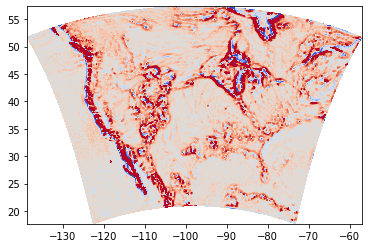

In [31]:
plt.contourf(lon_wrf,lat_wrf, Boyancy[0,0,:,:], cmap='coolwarm', levels=np.linspace(-0.06,0.06,21), extend='both')